## 2. Análisis de Sentimiento

Implementación y evaluación de un modelo de análisis de sentimiento.

El objetivo principal es el de realizar un **modelo de clasificación binaria**. Se valorará positivamente comparar la variación en los resultados al usar **diferentes modelos**, al **modificar algún paso en la etapa de preprocesado** (stemming vs no stemming, p.ej.), así como la comparación de resultados utilizando o bien **modelos pre-entrenados** o modelos más simples (como VADER).

Se utilizará alguno de los datasets disponibles de **reviews de Amazon**.

Soluciones más avanzadas como por ejemplo modelos de clasificación multi-clase o basados en embeddings serán valorables.

In [253]:
# Importamos lo que vayamos a necesitar
import pandas as pd
import numpy as np
import string

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

from collections import Counter
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.stem.snowball import EnglishStemmer

# Nuestras funciones del archivo utils, para el procesado del texto
from utils import file_to_dict, process_text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import OneHotEncoder


# borrar
from multiprocessing.pool import Pool
from functools import partial
from os import cpu_count

### 1. Importamos y procesamos nuestros datos

In [2]:
data = pd.read_csv('./datasets/reviews.csv')

In [3]:
data['rating_binary_label'] = data['rating'].apply(lambda it: 'pos' if it > 3 else 'neg')

In [4]:
data['rating_triary_label'] = data['rating'].apply(lambda it: 'pos' if it > 3 else ('neu' if it == 3 else 'neg'))

In [5]:
# Vemos que ha creado nuestra neuva columna
data.head()

,review,rating,helpful,category,rating_binary_label,rating_triary_label
0,A fun way to bling up your desk and make sure ...,4,1.0,Office products,pos,pos
1,I continue to love this show. Raylan and the r...,5,0.0,Amazon instant videos,pos,pos
2,Arrived in super flash time. Like another rev...,5,0.0,Patio lawn/garden,pos,pos
3,This treat ball works as expected. I used Temp...,4,0.5,Pet supplies,pos,pos
4,I know it's extrange but it works! It is easy ...,4,0.0,Baby,pos,pos


In [14]:
# Constants
lemas = file_to_dict('./datasets/lemmatization-en.txt')
min_length = 50
en_stop_words = gensim.parsing.preprocessing.STOPWORDS
translate_table = dict((ord(char), None) for char in string.punctuation)  
lang='en'
stemmer = EnglishStemmer(ignore_stopwords=True)

In [15]:
def process_row(row):    
    if type(row['review']) is str:    
        aux = process_text(min_length, lemas, translate_table, en_stop_words, 'en', None, row['review'])
        if aux:
            return {
                'review': ' '.join(aux),
                'review_processed': aux,
                'category': row['category'],
                'rating_binary_label': row['rating_binary_label'],
                'rating_triary_label': row['rating_triary_label']
            }

In [186]:
cpu_count()

12

In [16]:
pool = Pool(cpu_count())
df = [it for it in pool.map(process_row, [row for index, row in data.iterrows()]) if it]
pool.close()
df = pd.DataFrame(list(df))
df.dropna(inplace=True)

In [17]:
df

,review,review_processed,category,rating_binary_label,rating_triary_label
0,ways bling desks making surest ones guys wants...,"[ways, bling, desks, making, surest, ones, guy...",Office products,pos,pos
1,continuing loving shows raylan rests character...,"[continuing, loving, shows, raylan, rests, cha...",Amazon instant videos,pos,pos
2,arrived super flashing timing like reviewers h...,"[arrived, super, flashing, timing, like, revie...",Patio lawn/garden,pos,pos
3,this treats balls works expected tempations ca...,"[this, treats, balls, works, expected, tempati...",Pet supplies,pos,pos
4,knows extrange buts works easiest cleans eight...,"[knows, extrange, buts, works, easiest, cleans...",Baby,pos,pos
...,...,...,...,...,...
177121,second years happiest straps locks great products,"[second, years, happiest, straps, locks, great...",Musical instruments,pos,pos
177122,this units says evens tried outs friends dodge...,"[this, units, says, evens, tried, outs, friend...",Automotive,pos,pos
177123,years smead hangings folders they plastics rem...,"[years, smead, hangings, folders, they, plasti...",Office products,pos,pos
177124,pros dons needs touching deads looks cons silv...,"[pros, dons, needs, touching, deads, looks, co...",Patio lawn/garden,neg,neu


## Separamos en train test

In [126]:
def train_test_splt(values, labels):
    print('Spliting...')
    return train_test_split(
        values,
        labels,
        train_size=0.75,
        test_size=0.25,
        random_state=42,
        shuffle=True,
        stratify=labels
    )

In [127]:
X_train, X_test, y_train, y_test = train_test_splt(df['review'], df['rating_binary_label'])
X_train, X_validation, y_train, y_validation= train_test_splt(X_train, y_train)

Spliting...
Spliting...


## Extraccion de caracteristicas

In [234]:
def plot_chi_square(values, labels, words_to_show=10): 
    # Compute the chi-squared score for each word in the training set and show the values
    chi2score = chi2(values, labels)[0]
    scores = list(zip(cv.get_feature_names(), chi2score))
    sorted_scores = sorted(scores, key=lambda x:x[1])
    topchi2 = list(zip(*sorted_scores[-words_to_show:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]

    plt.figure(figsize=(12, 8))
    plt.barh(x,topchi2[1], align='center', alpha=0.5)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=12)
    plt.xlabel(r'$\chi^2$', fontsize=26)
    plt.ylabel('word', fontsize=16)
    plt.title(r'Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.show();

In [128]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1,1)
)
cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_validation_ = cv.transform(X_validation)
X_test_ = cv.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [129]:
print(list(cv.vocabulary_.items())[:20])

[('this', 2220), ('nicest', 1407), ('portables', 1613), ('airs', 49), ('compressors', 412), ('liking', 1194), ('facts', 709), ('powers', 1634), ('gauging', 865), ('settings', 1893), ('desired', 532), ('pressuring', 1641), ('dons', 569), ('stood', 2085), ('rights', 1804), ('watching', 2392), ('coursing', 460), ('exacts', 682), ('buts', 267), ('closing', 374)]


In [131]:
words_example = [
    'this',
    'like',
    'good',
    'great',
    'dont',
]

In [132]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
this                2.189
like                4.663
good                4.460
great               3.989
dont                2.721


In [133]:
import random
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 75723
Sentiment: neg
Review: tomatoes gardeners twentieth years supports means this cage mights determinate tomatoes buts outs controls constantly growing indeterminate varieties especially largest fruits wills useless first items came ridiculously bubbling wrapped extremely frustrating gotten undone managed broken snaps renderings supports useless fault buts defenses bubbling wrapt tights glued wasn easiest opens stakes shorts fifth strong steels coring stakes laughable bests these strong steels coring stakes stakes available home depot lowes locals nurseries whiling okays strong words describing wants strongest gotten rebars ended putting strong steels coring stakes obelisks cucumbers fitting perfectly attached second remaining rows supports


In [134]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 75723:
               tfidf
stakes      0.639491
steels      0.301037
supports    0.276891
tomatoes    0.222456
useless     0.213501
wrapped     0.116683
describing  0.115358
fruits      0.114922
managed     0.111738
wrapt       0.110921

Top 10 words with lowest TF_IDF in the review 75723:
            tfidf
second   0.062279
whiling  0.061499
wants    0.058468
bests    0.057502
putting  0.055402
years    0.052684
easiest  0.052257
wills    0.043348
outs     0.040988
this     0.038023


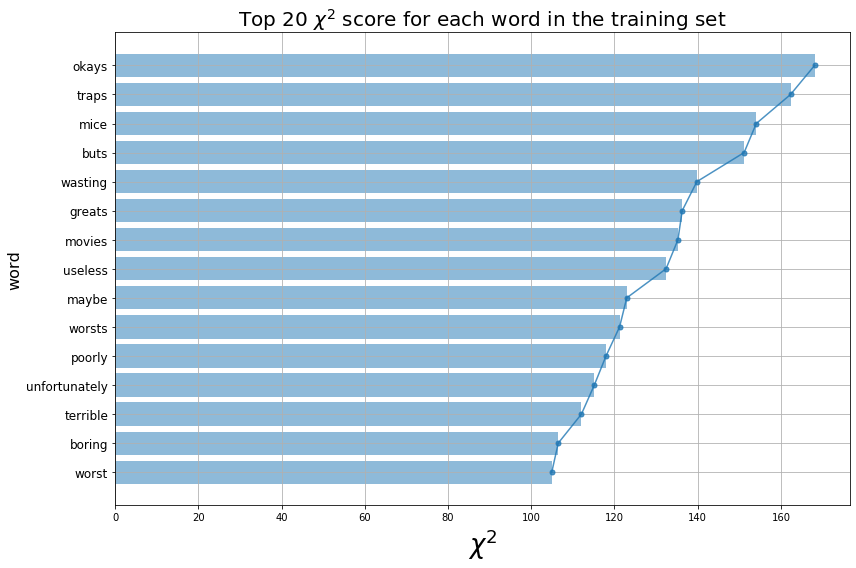

In [236]:
plot_chi_square(X_train_, y_train, 15)

## Evaluacion del modelo

In [310]:
def evaluation(model, values, labels):
    test_predict = model.predict(values)
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

In [184]:
def plot_values(values, max_idx, labels):
    plt.figure(figsize=(12, 8))
    for d in values:
        plt.plot(d.get('value'), label=d.get('label'))
    plt.axvline(max_idx, c='g', ls='--', alpha=0.8)
    plt.title('Accuracy evolution for different C values')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.xticks(list(range(len(labels))), labels)
    plt.tight_layout()
    plt.show()

In [188]:
def dict_creator(lr, tp, vp, tacc, vacc): 
    return {
        'model': lr,
        'predictions': {
            'train': tp,
            'validation': vp
        },
        'accuracy': {
            'train': tacc,
            'validation': vacc
        }
    }

In [189]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

def grid_executor(c_params, solvers, max_iter, X_train, y_train, X_val, y_val):

    res = []
    for c in c_params:
        for solver in solvers:
            print(f'Evaluating model with C={c}, solver={solver}, max_iter={max_iter}')
            lr = LogisticRegression(C=c, solver=solver, max_iter=max_iter)
            lr.fit(X_train_, y_train)

            train_predict = lr.predict(X_train_)
            validation_predict = lr.predict(X_validation_)
            
            train_acc = accuracy_score(y_train, train_predict)
            validation_acc = accuracy_score(y_val, validation_predict)

            print (f"Accuracy train: {train_acc}, val: {validation_acc}")
            
            res.append(dict_creator(lr, train_predict, validation_predict, train_acc, validation_acc))
    return res

In [242]:
def plot_accuracy_evolution(grid):
    train_acc = []
    val_acc = []
    for aux in grid:
        train,val = aux.get('accuracy').values()
        train_acc.append(train)
        val_acc.append(val)

    values = [
        {'label': 'train', 'value': train_acc},
        {'label': 'validation', 'value': val_acc}
    ]

    optimal_model_idx = np.argmax(val_acc)

    plot_values(values, optimal_model_idx, c_params)
    
    return optimal_model_idx

In [190]:


c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]
solvers  = ['lbfgs']
max_iter = 500

grid = grid_executor(c_params, solvers, max_iter, X_train_, y_train, X_validation_, y_validation)


Evaluating model with C=0.01, solver=lbfgs, max_iter=500
Accuracy train: 0.8325855891120412, val: 0.8325855891120412
Evaluating model with C=0.05, solver=lbfgs, max_iter=500
Accuracy train: 0.8399124787971857, val: 0.8397518894342236
Evaluating model with C=0.25, solver=lbfgs, max_iter=500
Accuracy train: 0.8650848614414902, val: 0.8605281382674415
Evaluating model with C=0.5, solver=lbfgs, max_iter=500
Accuracy train: 0.8730842190840384, val: 0.8670320074674054
Evaluating model with C=1, solver=lbfgs, max_iter=500
Accuracy train: 0.8772495056858671, val: 0.8706753786396073
Evaluating model with C=10, solver=lbfgs, max_iter=500
Accuracy train: 0.8806620296488111, val: 0.8713076992562705
Evaluating model with C=100, solver=lbfgs, max_iter=500
Accuracy train: 0.8813244607710297, val: 0.8707355996507181
Evaluating model with C=1000, solver=lbfgs, max_iter=500
Accuracy train: 0.881424829122881, val: 0.8707355996507181
Evaluating model with C=10000, solver=lbfgs, max_iter=500
Accuracy train

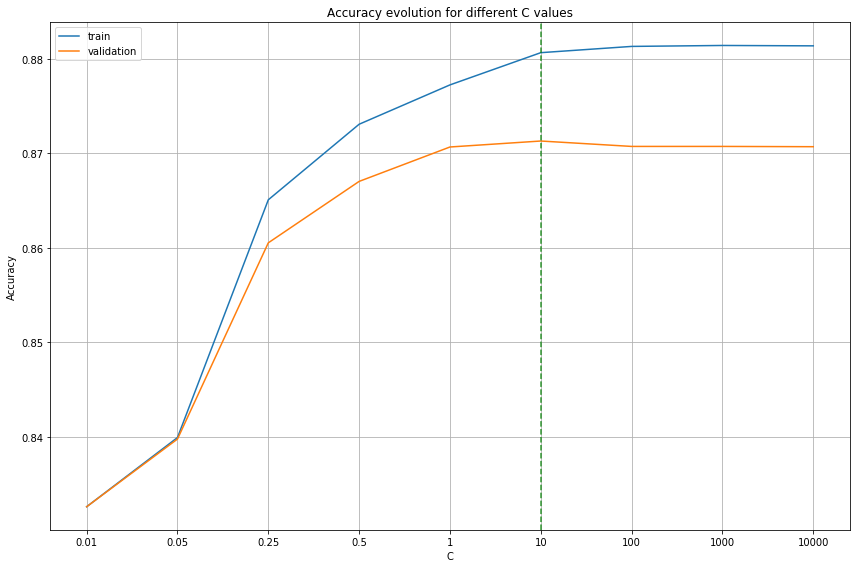

In [243]:
optimal_model_idx = plot_accuracy_evolution(grid)

In [194]:
evaluation(grid[optimal_model_idx].get('model'), X_test, y_test)

Confussion matrix:
[[ 3215  4199]
 [ 1563 35305]]

Classification report:
              precision    recall  f1-score   support

         neg       0.67      0.43      0.53      7414
         pos       0.89      0.96      0.92     36868

    accuracy                           0.87     44282
   macro avg       0.78      0.70      0.73     44282
weighted avg       0.86      0.87      0.86     44282

Accuracy score:0.869879409240775


## Comprobamos nuestro modelo

In [217]:
CRED = '\033[41m'
CGREEN = '\033[42m'
CEND = '\033[0m'

In [220]:
def predict_review_sentiment(cv, reviews, labels, num_samples):
    for i in range(num_samples):
        index = random.choice(X_test.index)
        r = reviews[index]
        
        prediction = lr.predict(cv.transform([r]))[0]
        
        color = (CRED, CGREEN)[labels[index] == prediction]
        print(f"Comprobando review {index}")
        print(f"{color}Sentimiento {labels[index]} - {prediction}{CEND}")

In [221]:
predict_review_sentiment(cv, X_test, y_test, 10)

Comprobando review 172126
Sentimiento pos - pos
Comprobando review 159051
Sentimiento neg - pos
Comprobando review 130369
Sentimiento pos - pos
Comprobando review 156616
Sentimiento pos - pos
Comprobando review 100066
Sentimiento pos - pos
Comprobando review 175680
Sentimiento pos - pos
Comprobando review 6876
Sentimiento pos - pos
Comprobando review 81807
Sentimiento pos - pos
Comprobando review 56846
Sentimiento pos - pos
Comprobando review 55521
Sentimiento pos - pos


Como vemos la moyoria de preducciones con correctas, el menos podemos afirmar eso para unas etiquetas binarias, vamos a probar ahora con 3 'sentimientos'

## Vamos a probar ahora con VADER

In [249]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [251]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [252]:
sentiment_analyzer_scores("The phone is super cool.")

The phone is super cool.---------------- {'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}


## Evaluacion para 3 etiquetas

In [271]:
X_train, X_test, y_train, y_test = train_test_splt(df['review'], df['rating_triary_label'])
X_train, X_validation, y_train, y_validation= train_test_splt(X_train, y_train)

Spliting...
Spliting...


In [278]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.transform(y_validation)
y_test = encoder.transform(y_test)

In [273]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1,1)
)
cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_validation_ = cv.transform(X_validation)
X_test_ = cv.transform(X_test)

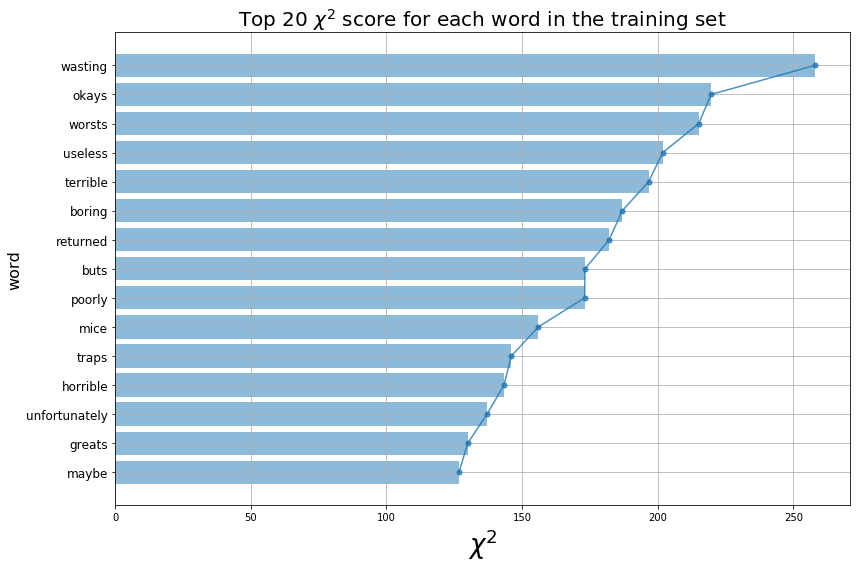

In [274]:
plot_chi_square(X_train_, y_train, 15)

In [280]:
lr = LogisticRegression(C=1, solver='saga', max_iter=500)
lr.fit(X_train_, y_train)

ValueError: bad input shape (99633, 3)

In [283]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [292]:
def create_mlp(dim, epochs=200,lr = 1e-2, n_classes=4, regress=False):
  # Creamos nuestra red
  model = Sequential()
  model.add(Dense(8, input_dim=dim, activation="relu", name='mlp_dense_1'))
  model.add(Dense(n_classes, activation="softmax", name='mlp_classification_output'))
  # Comprobar si es un problema de regresion
  if regress:
    model.add(Dense(1, activation="linear", name='mlp_regression_output'))

  # Creamos el optimizador 
  opt = Adam(lr=lr)
  # Compilamos nuestro modelo
  loss_function = ('categorical_crossentropy', 'mean_squared_error')[regress]
  # Seleccionamos las metricas que querramos
  metrics = (['accuracy'],[])[regress]

  model.compile(loss=loss_function, optimizer=opt, metrics=metrics)
  # return our model
  return model

In [300]:
# Valores por defecto para las variables
epochs = 50
n_classes = 3
regress = False
lr = 1e-2

In [301]:
def scheduler(epoch,lr): 
    return (lr, lr * np.exp(-0.1*lr))[epoch % 5 == 0]

In [302]:
# Creamos y entrenamos nuestro modelo
model = create_mlp(X_train_.shape[1], epochs=epochs, n_classes=n_classes, lr=lr, regress=regress)

scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

costs = model.fit(X_train_, y_train,
    epochs=epochs, 
    batch_size=8, 
    validation_data=(X_validation_, y_validation),
    callbacks=[scheduler_callback]
)

Train on 99633 samples, validate on 33211 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009990004775263031.
Epoch 1/50
99633/99633 [==============================] - 15s 151us/sample - loss: 0.4303 - acc: 0.8452 - val_loss: 0.4018 - val_acc: 0.8515

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009990004822611809.
Epoch 2/50
99633/99633 [==============================] - 13s 135us/sample - loss: 0.3834 - acc: 0.8601 - val_loss: 0.3926 - val_acc: 0.8587

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009990004822611809.
Epoch 3/50
99633/99633 [==============================] - 13s 135us/sample - loss: 0.3608 - acc: 0.8677 - val_loss: 0.3871 - val_acc: 0.8610

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009990004822611809.
Epoch 4/50
99633/99633 [==============================] - 14s 138us/sample - loss: 0.3434 - acc: 0.8725 - val_loss: 0.3889 - val_acc: 0.8634

Epoch 00005: LearningRateScheduler reducing learn

99633/99633 [==============================] - 14s 142us/sample - loss: 0.2541 - acc: 0.9088 - val_loss: 0.5611 - val_acc: 0.8510

Epoch 00038: LearningRateScheduler reducing learning rate to 0.009920595213770866.
Epoch 38/50
99633/99633 [==============================] - 13s 135us/sample - loss: 0.2540 - acc: 0.9092 - val_loss: 0.5339 - val_acc: 0.8630

Epoch 00039: LearningRateScheduler reducing learning rate to 0.009920595213770866.
Epoch 39/50
99633/99633 [==============================] - 14s 142us/sample - loss: 0.2535 - acc: 0.9100 - val_loss: 0.5068 - val_acc: 0.8703

Epoch 00040: LearningRateScheduler reducing learning rate to 0.009920595213770866.
Epoch 40/50
99633/99633 [==============================] - 14s 140us/sample - loss: 0.2532 - acc: 0.9100 - val_loss: 0.5241 - val_acc: 0.8679

Epoch 00041: LearningRateScheduler reducing learning rate to 0.009910758273053445.
Epoch 41/50
99633/99633 [==============================] - 15s 153us/sample - loss: 0.2516 - acc: 0.9110 - v

In [304]:
scores = model.evaluate(X_test_, y_test)
print(f' Loss: {scores[0]} | Accuracy: {scores[1]}')

44282/44282 [==============================] - 1s 19us/sample - loss: 0.5325 - acc: 0.8703
 Loss: 0.5325119616167234 | Accuracy: 0.8702858686447144


In [315]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [309]:
model.predict(X_test_)

array([[3.8827890e-01, 2.1359749e-01, 3.9812359e-01],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 6.0845287e-35, 1.0000000e+00],
       ...,
       [6.6661546e-03, 1.5729709e-04, 9.9317652e-01],
       [2.5866161e-08, 9.5184885e-07, 9.9999905e-01],
       [4.2542116e-08, 5.2743059e-07, 9.9999940e-01]], dtype=float32)

In [314]:
# print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
# print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [311]:
evaluation(model, X_test_, y_test)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [267]:

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100]
solvers  = ['lbfgs']
max_iter = 1000

grid = grid_executor(c_params, solvers, max_iter, X_train_, y_train, X_validation_, y_validation)


Evaluating model with C=0.01, solver=lbfgs, max_iter=1000


ValueError: bad input shape (99633, 3)

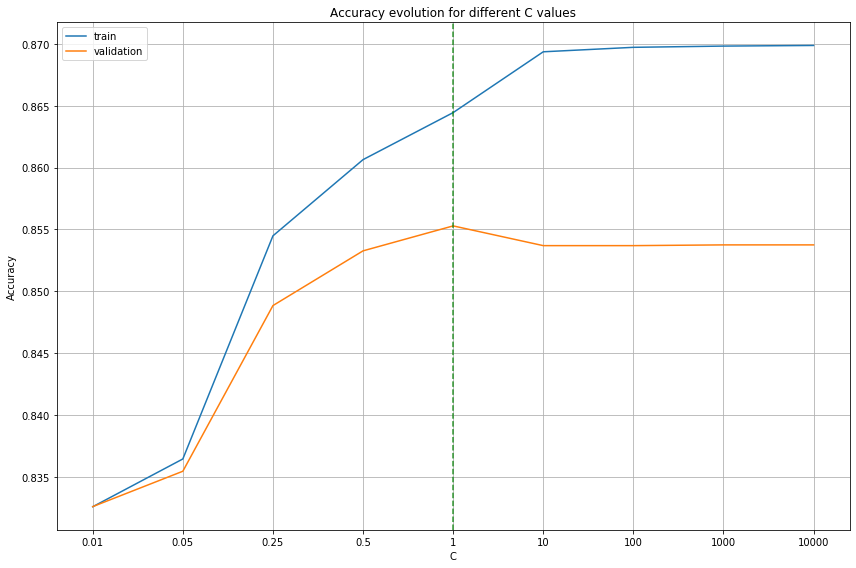

In [245]:
optimal_model_idx = plot_accuracy_evolution(grid)

In [246]:
evaluation(grid[optimal_model_idx].get('model'), X_test, y_test)

Confussion matrix:
[[  367     0  2897]
 [  443     0  3706]
 [ 3968     0 32901]]


/home/alberto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification report:
              precision    recall  f1-score   support

         neg       0.08      0.11      0.09      3264
         neu       0.00      0.00      0.00      4149
         pos       0.83      0.89      0.86     36869

    accuracy                           0.75     44282
   macro avg       0.30      0.33      0.32     44282
weighted avg       0.70      0.75      0.72     44282

Accuracy score:0.7512759134637098


In [248]:
predict_review_sentiment(cv, X_test, y_test, 20)

Comprobando review 163555
Sentimiento pos - pos
Comprobando review 85212
Sentimiento pos - pos
Comprobando review 79119
Sentimiento pos - pos
Comprobando review 141666
Sentimiento neu - neg
Comprobando review 116760
Sentimiento pos - pos
Comprobando review 62054
Sentimiento pos - pos
Comprobando review 111047
Sentimiento pos - neg
Comprobando review 96298
Sentimiento pos - pos
Comprobando review 118343
Sentimiento pos - pos
Comprobando review 55800
Sentimiento pos - neg
Comprobando review 174531
Sentimiento pos - pos
Comprobando review 15324
Sentimiento pos - pos
Comprobando review 8822
Sentimiento neu - pos
Comprobando review 66014
Sentimiento pos - pos
Comprobando review 48484
Sentimiento neg - neg
Comprobando review 48512
Sentimiento pos - pos
Comprobando review 168424
Sentimiento pos - pos
Comprobando review 131149
Sentimiento neg - neg
Comprobando review 110794
Sentimiento pos - pos
Comprobando review 162192
Sentimiento pos - pos
